In [20]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
X = data.data
y = data.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    exps = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exps / (np.sum(exps, axis=0, keepdims=True) + 1e-10)

def softmax_derivative(x):
    p = softmax(x)
    return p * (1 - p)

def hidden_activation(x, k0, k1):
    return k0 + k1 * x

def hidden_activation_derivative(x, k0, k1):
    return k1

n_i = X_train.shape[1]  # Number of inputs
n_o = 2  # Number of outputs

learning_rate = 0.21

hidden_layer_sizes = [60, 90, 100, 110, 500]
kf = KFold(n_splits=3)

best_train_f1 = -np.inf
best_train_accuracy = -np.inf
best_test_f1 = -np.inf
best_test_accuracy = -np.inf
best_n_h = None

f1_scores = {}
train_losses = {}
train_f1_scores = {}

for n_h in hidden_layer_sizes:
    f1_scores[n_h] = []
    train_losses[n_h] = []
    train_f1_scores[n_h] = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        k0 = np.random.randn()
        k1 = np.random.randn()

        np.random.seed(42)
        W1 = np.random.randn(n_h, n_i)
        b1 = np.zeros(n_h)
        W2 = np.random.randn(n_o, n_h)
        b2 = np.zeros(n_o)

        for epoch in range(1000):
            Z1 = np.dot(W1, X_train_fold.T) + b1[:, None]
            A1 = hidden_activation(Z1, k0, k1)
            Z2 = np.dot(W2, A1) + b2[:, None]
            A2 = softmax(Z2)

            epsilon = 1e-7  # small constant
            A2_clipped = np.clip(A2, epsilon, 1 - epsilon)  # avoid extreme values
            loss = -np.mean(y_train_fold * np.log(A2_clipped))

            predictions_train = np.argmax(A2, axis=0)
            f1 = f1_score(y_train_fold, predictions_train, average="macro")

            f1_scores[n_h].append(f1)
            train_losses[n_h].append(loss)
            train_f1_scores[n_h].append(f1)

            dZ2 = A2 - y_train_fold[None, :]
            dW2 = np.dot(dZ2, A1.T) / X_train_fold.shape[0]
            db2 = np.sum(dZ2, axis=1) / X_train_fold.shape[0]
            dZ1 = np.dot(W2.T, dZ2) * hidden_activation_derivative(Z1, k0, k1)
            dW1 = np.dot(dZ1, X_train_fold) / X_train_fold.shape[0]
            db1 = np.sum(dZ1, axis=1) / X_train_fold.shape[0]

            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2

        Z1 = np.dot(W1, X_val_fold.T) + b1[:, None]
        A1 = hidden_activation(Z1, k0, k1)
        Z2 = np.dot(W2, A1) + b2[:, None]
        A2 = softmax(Z2)
        predictions_val = np.argmax(A2, axis=0)

        f1_val = f1_score(y_val_fold, predictions_val, average="macro")
        accuracy_val = accuracy_score(y_val_fold, predictions_val)

        if f1_val > best_test_f1:
            best_train_f1 = np.mean(f1_scores[n_h])
            best_train_accuracy = accuracy_score(y_train_fold, predictions_train)
            best_test_f1 = f1_val
            best_test_accuracy = accuracy_val
            best_n_h = n_h

    print(f"\nNumber of nodes: {n_h}")
    print(f"Train F1-score: {np.mean(f1_scores[n_h])}")
    print(f"Train Accuracy: {accuracy_score(y_train_fold, predictions_train)}")
    print(f"Validation F1-score: {f1_val}")
    print(f"Validation Accuracy: {accuracy_val}")

# Retrain the model with the entire training data using the best number of nodes in the hidden layer
k0 = np.random.randn()
k1 = np.random.randn()

np.random.seed(42)
W1 = np.random.randn(best_n_h, n_i)
b1 = np.zeros(best_n_h)
W2 = np.random.randn(n_o, best_n_h)
b2 = np.zeros(n_o)

for epoch in range(1000):
    Z1 = np.dot(W1, X_train.T) + b1[:, None]
    A1 = hidden_activation(Z1, k0, k1)
    Z2 = np.dot(W2, A1) + b2[:, None]
    A2 = softmax(Z2)

    epsilon = 1e-7  # small constant
    A2_clipped = np.clip(A2, epsilon, 1 - epsilon)  # avoid extreme values
    loss = -np.mean(y_train * np.log(A2_clipped))

    predictions_train = np.argmax(A2, axis=0)

    dZ2 = A2 - y_train[None, :]
    dW2 = np.dot(dZ2, A1.T) / X_train.shape[0]
    db2 = np.sum(dZ2, axis=1) / X_train.shape[0]
    dZ1 = np.dot(W2.T, dZ2) * hidden_activation_derivative(Z1, k0, k1)
    dW1 = np.dot(dZ1, X_train) / X_train.shape[0]
    db1 = np.sum(dZ1, axis=1) / X_train.shape[0]

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

# Test the model on the test data
Z1 = np.dot(W1, X_test.T) + b1[:, None]
A1 = hidden_activation(Z1, k0, k1)
Z2 = np.dot(W2, A1) + b2[:, None]
A2 = softmax(Z2)
predictions_test = np.argmax(A2, axis=0)

f1_test = f1_score(y_test, predictions_test, average="macro")
accuracy_test = accuracy_score(y_test, predictions_test)

print("\nBest model:")
print(f"Number of nodes: {best_n_h}")
print(f"Train F1-score: {best_train_f1}")
print(f"Train Accuracy: {best_train_accuracy}")
print(f"Test F1-score: {f1_test}")
print(f"Test Accuracy: {accuracy_test}")



Number of nodes: 60
Train F1-score: 0.49766129185136804
Train Accuracy: 0.05921052631578947
Validation F1-score: 0.9385762711864407
Validation Accuracy: 0.9403973509933775


/tmp/ipykernel_498108/152309723.py:25: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(x - np.max(x, axis=0, keepdims=True))
/tmp/ipykernel_498108/152309723.py:25: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(x - np.max(x, axis=0, keepdims=True))



Number of nodes: 90
Train F1-score: 0.44116193333920306
Train Accuracy: 0.34539473684210525
Validation F1-score: 0.29767441860465116
Validation Accuracy: 0.423841059602649


/tmp/ipykernel_498108/152309723.py:25: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(x - np.max(x, axis=0, keepdims=True))



Number of nodes: 100
Train F1-score: 0.47059821723908773
Train Accuracy: 0.06578947368421052
Validation F1-score: 0.9385762711864407
Validation Accuracy: 0.9403973509933775


/tmp/ipykernel_498108/152309723.py:25: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(x - np.max(x, axis=0, keepdims=True))
/tmp/ipykernel_498108/152309723.py:25: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(x - np.max(x, axis=0, keepdims=True))



Number of nodes: 110
Train F1-score: 0.4311548609780956
Train Accuracy: 0.34539473684210525
Validation F1-score: 0.29767441860465116
Validation Accuracy: 0.423841059602649


/tmp/ipykernel_498108/152309723.py:25: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(x - np.max(x, axis=0, keepdims=True))



Number of nodes: 500
Train F1-score: 0.45508447503246113
Train Accuracy: 0.07236842105263158
Validation F1-score: 0.9385762711864407
Validation Accuracy: 0.9403973509933775

Best model:
Number of nodes: 60
Train F1-score: 0.49766129185136804
Train Accuracy: 0.05921052631578947
Test F1-score: 0.9626596790042581
Test Accuracy: 0.9649122807017544


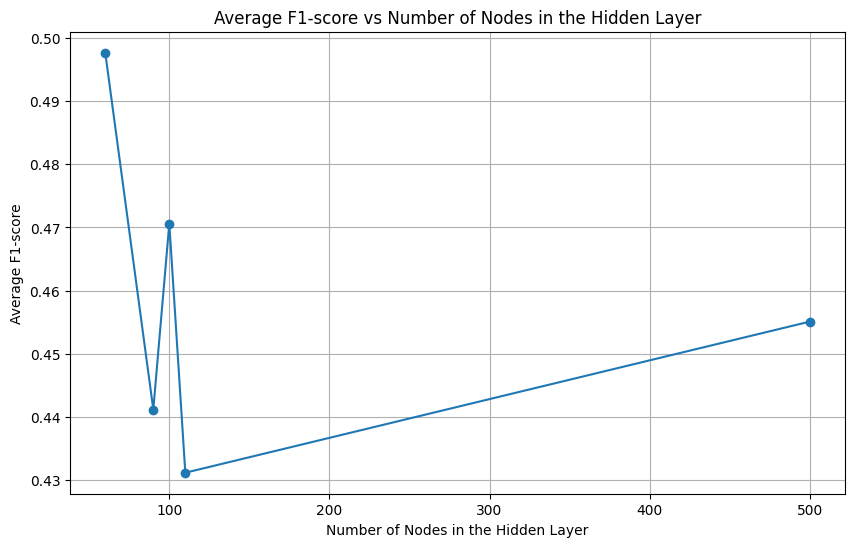

In [21]:
import matplotlib.pyplot as plt

# Number of nodes in the hidden layer
nodes = [60, 90, 100, 110, 500]

# Average F1-scores for each number of nodes
avg_f1_scores = [np.mean(f1_scores[n_h]) for n_h in nodes]

plt.figure(figsize=(10, 6))
plt.plot(nodes, avg_f1_scores, marker='o')
plt.title('Average F1-score vs Number of Nodes in the Hidden Layer')
plt.xlabel('Number of Nodes in the Hidden Layer')
plt.ylabel('Average F1-score')
plt.grid(True)
plt.show()



Best model:
Number of nodes: 60
Train F1-score: 0.49766129185136804
Train Accuracy: 0.05921052631578947
Test F1-score: 0.9626596790042581
Test Accuracy: 0.9649122807017544


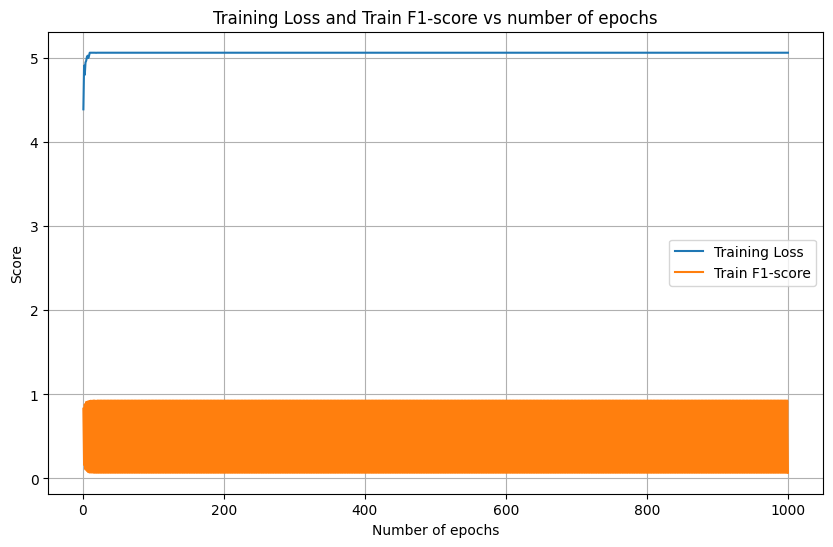

In [29]:
import matplotlib.pyplot as plt

# Initialize lists to store the training loss and F1-score for each epoch
train_losses = []
train_f1_scores = []

# Retrain the model with the entire training data using the best number of nodes in the hidden layer
k0 = np.random.randn()
k1 = np.random.randn()

np.random.seed(42)
W1 = np.random.randn(best_n_h, n_i)
b1 = np.zeros(best_n_h)
W2 = np.random.randn(n_o, best_n_h)
b2 = np.zeros(n_o)

for epoch in range(1000):
    Z1 = np.dot(W1, X_train.T) + b1[:, None]
    A1 = hidden_activation(Z1, k0, k1)
    Z2 = np.dot(W2, A1) + b2[:, None]
    A2 = softmax(Z2)

    epsilon = 1e-7  # small constant
    A2_clipped = np.clip(A2, epsilon, 1 - epsilon)  # avoid extreme values
    loss = -np.mean(y_train * np.log(A2_clipped))
    train_losses.append(loss)  # Store the training loss for this epoch

    predictions_train = np.argmax(A2, axis=0)
    f1 = f1_score(y_train, predictions_train, average="macro")
    train_f1_scores.append(f1)  # Store the training F1-score for this epoch

    dZ2 = A2 - y_train[None, :]
    dW2 = np.dot(dZ2, A1.T) / X_train.shape[0]
    db2 = np.sum(dZ2, axis=1) / X_train.shape[0]
    dZ1 = np.dot(W2.T, dZ2) * hidden_activation_derivative(Z1, k0, k1)
    dW1 = np.dot(dZ1, X_train) / X_train.shape[0]
    db1 = np.sum(dZ1, axis=1) / X_train.shape[0]

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

# Test the model on the test data
Z1 = np.dot(W1, X_test.T) + b1[:, None]
A1 = hidden_activation(Z1, k0, k1)
Z2 = np.dot(W2, A1) + b2[:, None]
A2 = softmax(Z2)
predictions_test = np.argmax(A2, axis=0)

f1_test = f1_score(y_test, predictions_test, average="macro")
accuracy_test = accuracy_score(y_test, predictions_test)

print("\nBest model:")
print(f"Number of nodes: {best_n_h}")
print(f"Train F1-score: {best_train_f1}")
print(f"Train Accuracy: {best_train_accuracy}")
print(f"Test F1-score: {f1_test}")
print(f"Test Accuracy: {accuracy_test}")

# Plot the training loss and F1-score for each epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1001), train_losses, label='Training Loss')
plt.plot(range(1, 1001), train_f1_scores, label='Train F1-score')
plt.title('Training Loss and Train F1-score vs number of epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()
